# Transcription factor binding motif enrichment - Luecken et al.

In [1]:
import anndata as ad
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from random import shuffle
from SEMITONES.support_funcs import sig_dictionary
from SEMITONES.support_funcs import sig_bool
from SEMITONES.enrichment_scoring import sig_interval
from scipy import stats
from itertools import compress

In [2]:
adata = ad.read_h5ad("../processed/Luecken_multiome_BMMC-r_adata.h5ad")

In [3]:
wnn_umap2= np.genfromtxt('../processed/Luecken_wnn_umap.csv', delimiter=',')

In [4]:
# Homer annotation
ann = pd.read_csv('../processed/Luecken_ATAC_ann_hg38.txt', sep='\t', index_col=0)
ann.sort_index(inplace=True)
ann.reset_index(drop=True, inplace=True)

In [5]:
ATAC_es = pd.read_hdf('../processed/Luecken_ATAC_escore.h5','escores')
ATAC_ps = pd.read_hdf('../processed/Luecken_ATAC_pscore.h5','pscores')

In [6]:
ATAC_interval = sig_interval(ATAC_ps, n_sds=10)
ATAC_sigdict_acc = sig_dictionary(ATAC_es, ATAC_interval, sign='positive')
ATAC_sigdict_inacc = sig_dictionary(ATAC_es, ATAC_interval, sign='negative')
ATAC_sigdict = sig_dictionary(ATAC_es, ATAC_interval)

In [12]:
bg_bed = pd.read_csv('../processed/Luecken_ATAC.bed', sep='\t',header=None)

In [10]:
def make_bed(bg_bed, sigdict, acc=None, typ='regions'):
    
    prom_set = set(np.where(ann['Annotation'].str.contains('promoter').fillna(False))[0])
    
    try:
        os.mkdir('../processed/Luecken/{}_{}'.format(acc, typ))
    except:
        pass

    for i in range(5):
        dir = '../processed/Luecken/{}_{}{}'.format(acc,typ,i)
        try:
            os.mkdir(dir)
        except:
            pass

        for f in os.listdir(dir):
            os.remove(os.path.join(dir, f))

        nstart = 0+i*20
        nend = 20+i*20
        rcells = ATAC_es.columns[nstart:nend]


        for rc in rcells:
            if typ=='prom':
                feat_id = list(prom_set.intersection(set(sigdict[rc])))
                df=bg_bed.loc[feat_id,:]
            else:
                df=bg_bed.loc[sigdict[rc],:]
            
            # in separate folders for motif enrich.
            df.to_csv('../processed/Luecken/{}_{}{}/{}.bed'.format(acc,typ,i,rc),header=None,index=None,sep='\t')

In [13]:
# make beds for proms
make_bed(bg_bed, ATAC_sigdict_acc, acc='acc', typ='prom')
make_bed(bg_bed, ATAC_sigdict_inacc, acc='inacc', typ='prom')

In [14]:
prom_set = set(np.where(ann['Annotation'].str.contains('promoter').fillna(False))[0])

In [16]:
# make prom_bg_bed
prom_bg_bed = bg_bed.iloc[list(prom_set),:].sort_index()
prom_bg_bed.to_csv('../processed/Luecken_ATAC_prom.bed', sep='\t',header=None, index=None)

In [17]:
prom_bg_bed = pd.read_csv('../processed/Luecken_ATAC_prom.bed', sep='\t',header=None)

Run the corresponding shell scripts in the *motif* folder to perform motif enrichment with Homer.

In [15]:
# summarize motif enrichment p values
def sum_p_motif(acc='acc', type='prom'):
    data_l = []
    dir = '../Luecken/{}_{}_motif'.format(acc, type)
    for folder in os.listdir(dir):
        cdir = '{}/{}'.format(dir,folder)
        try:
            res = pd.read_csv('{}/knownResults.txt'.format(cdir), sep='\t')
        except:
            
            continue
        res['Motif Name'] = res['Motif Name'].str.split('/',expand=True)[0]
        res.set_index('Motif Name', inplace=True)

        s=res['q-value (Benjamini)']
        s = s[~s.index.duplicated()]
        s.name = int(folder)
        #s.name = adata.obs['cell_type'][int(folder)]
        data_l.append(s)
    
    
    sum_p_motif = pd.concat(data_l, axis=1)
    # to include all rcells
    template_df = pd.DataFrame(columns=[int(x) for x in os.listdir(dir)])
    sum_p_motif = pd.concat([template_df,sum_p_motif]).fillna(1)
    # replace -inf with the maximum p-value
    sum_p_motif = -np.log10(sum_p_motif).replace({-np.inf:np.nan})
    sum_p_motif = sum_p_motif.fillna(np.max(np.max(sum_p_motif)))
    
    # change rcells into cell types
    sum_p_motif.set_axis(adata.obs['cell_type'][sum_p_motif.columns],axis=1,inplace=True)
    sum_p_motif.index.name = 'Motif Name'
    sum_p_motif.columns.name = None
    
    return sum_p_motif

/home/hliou/miniconda3/envs/mtproject/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/home/hliou/miniconda3/envs/mtproject/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/hliou/miniconda3/envs/mtproject/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


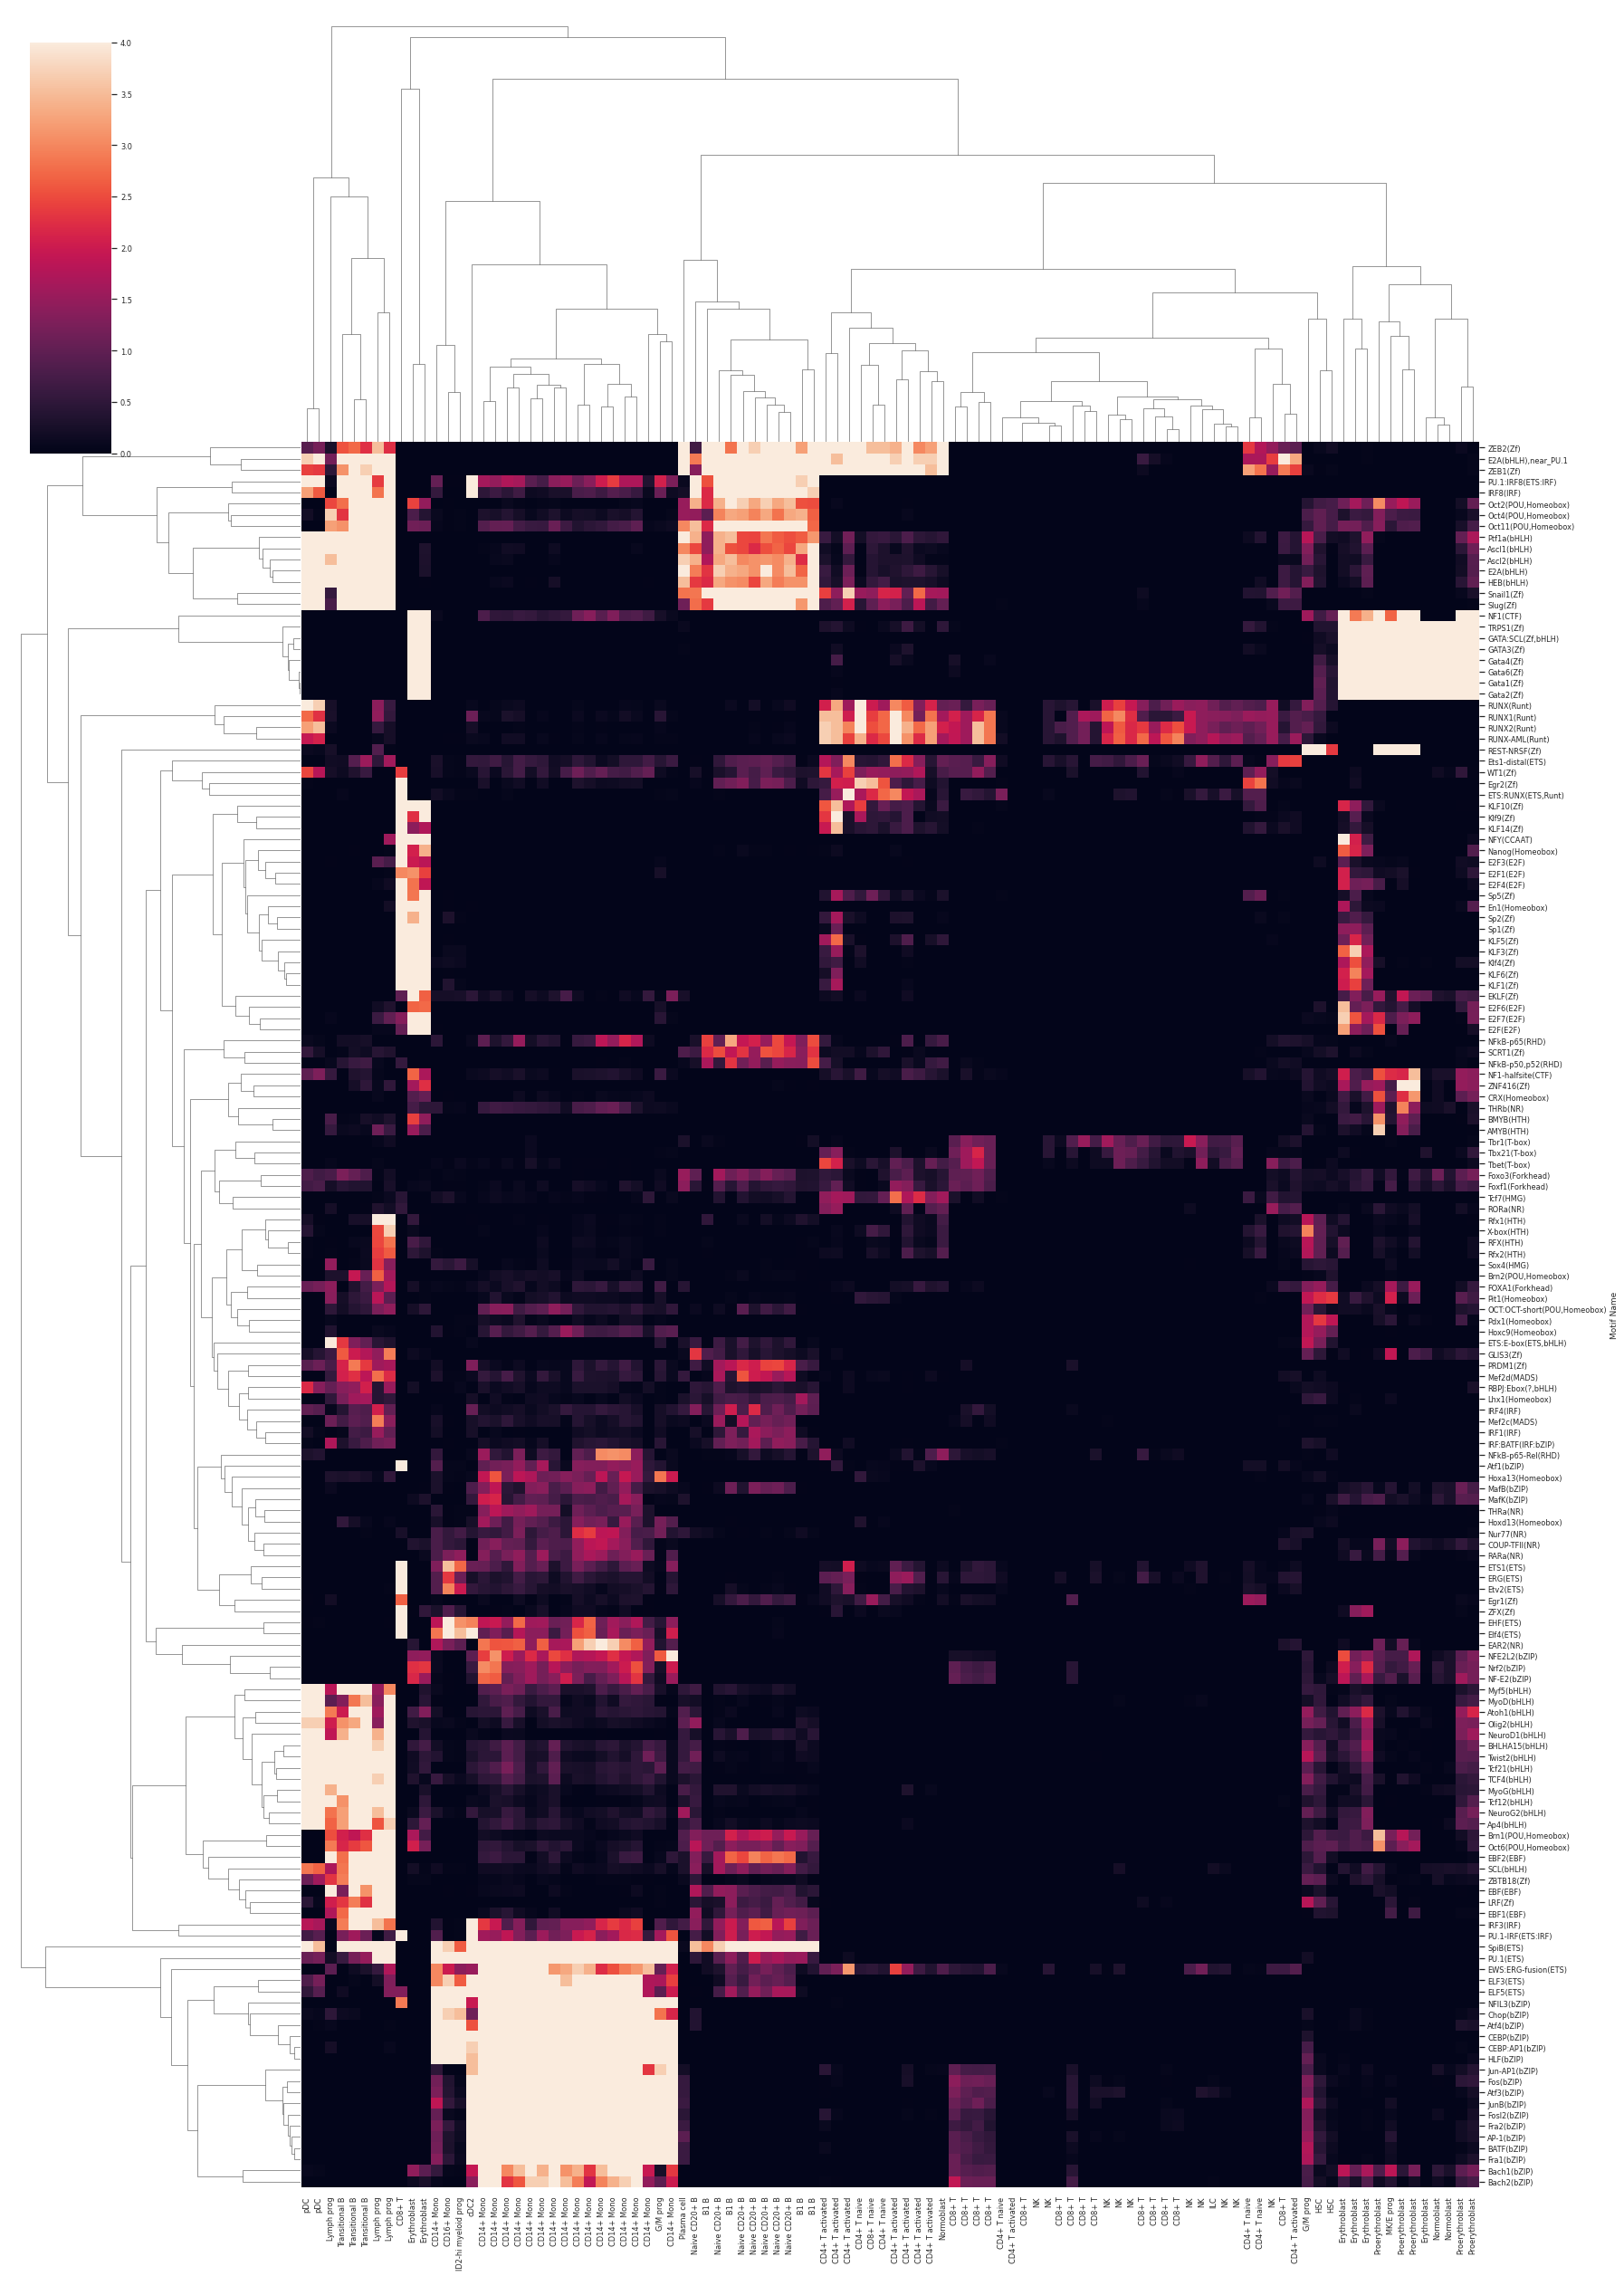

In [16]:
# enrichment results of selectively accessible promoters
sum_motif_acc = sum_p_motif(acc='acc', type='prom')
# each motif must be significantly enriched in at least 3 reference cells
sum_motif_acc = sum_motif_acc.loc[np.sum(sum_motif_acc>-np.log10(0.05),axis=1)>2,:]
sns.set(font_scale=0.75)
g=sns.clustermap(sum_motif_acc, figsize=(25,35))

/home/hliou/miniconda3/envs/mtproject/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/home/hliou/miniconda3/envs/mtproject/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/hliou/miniconda3/envs/mtproject/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


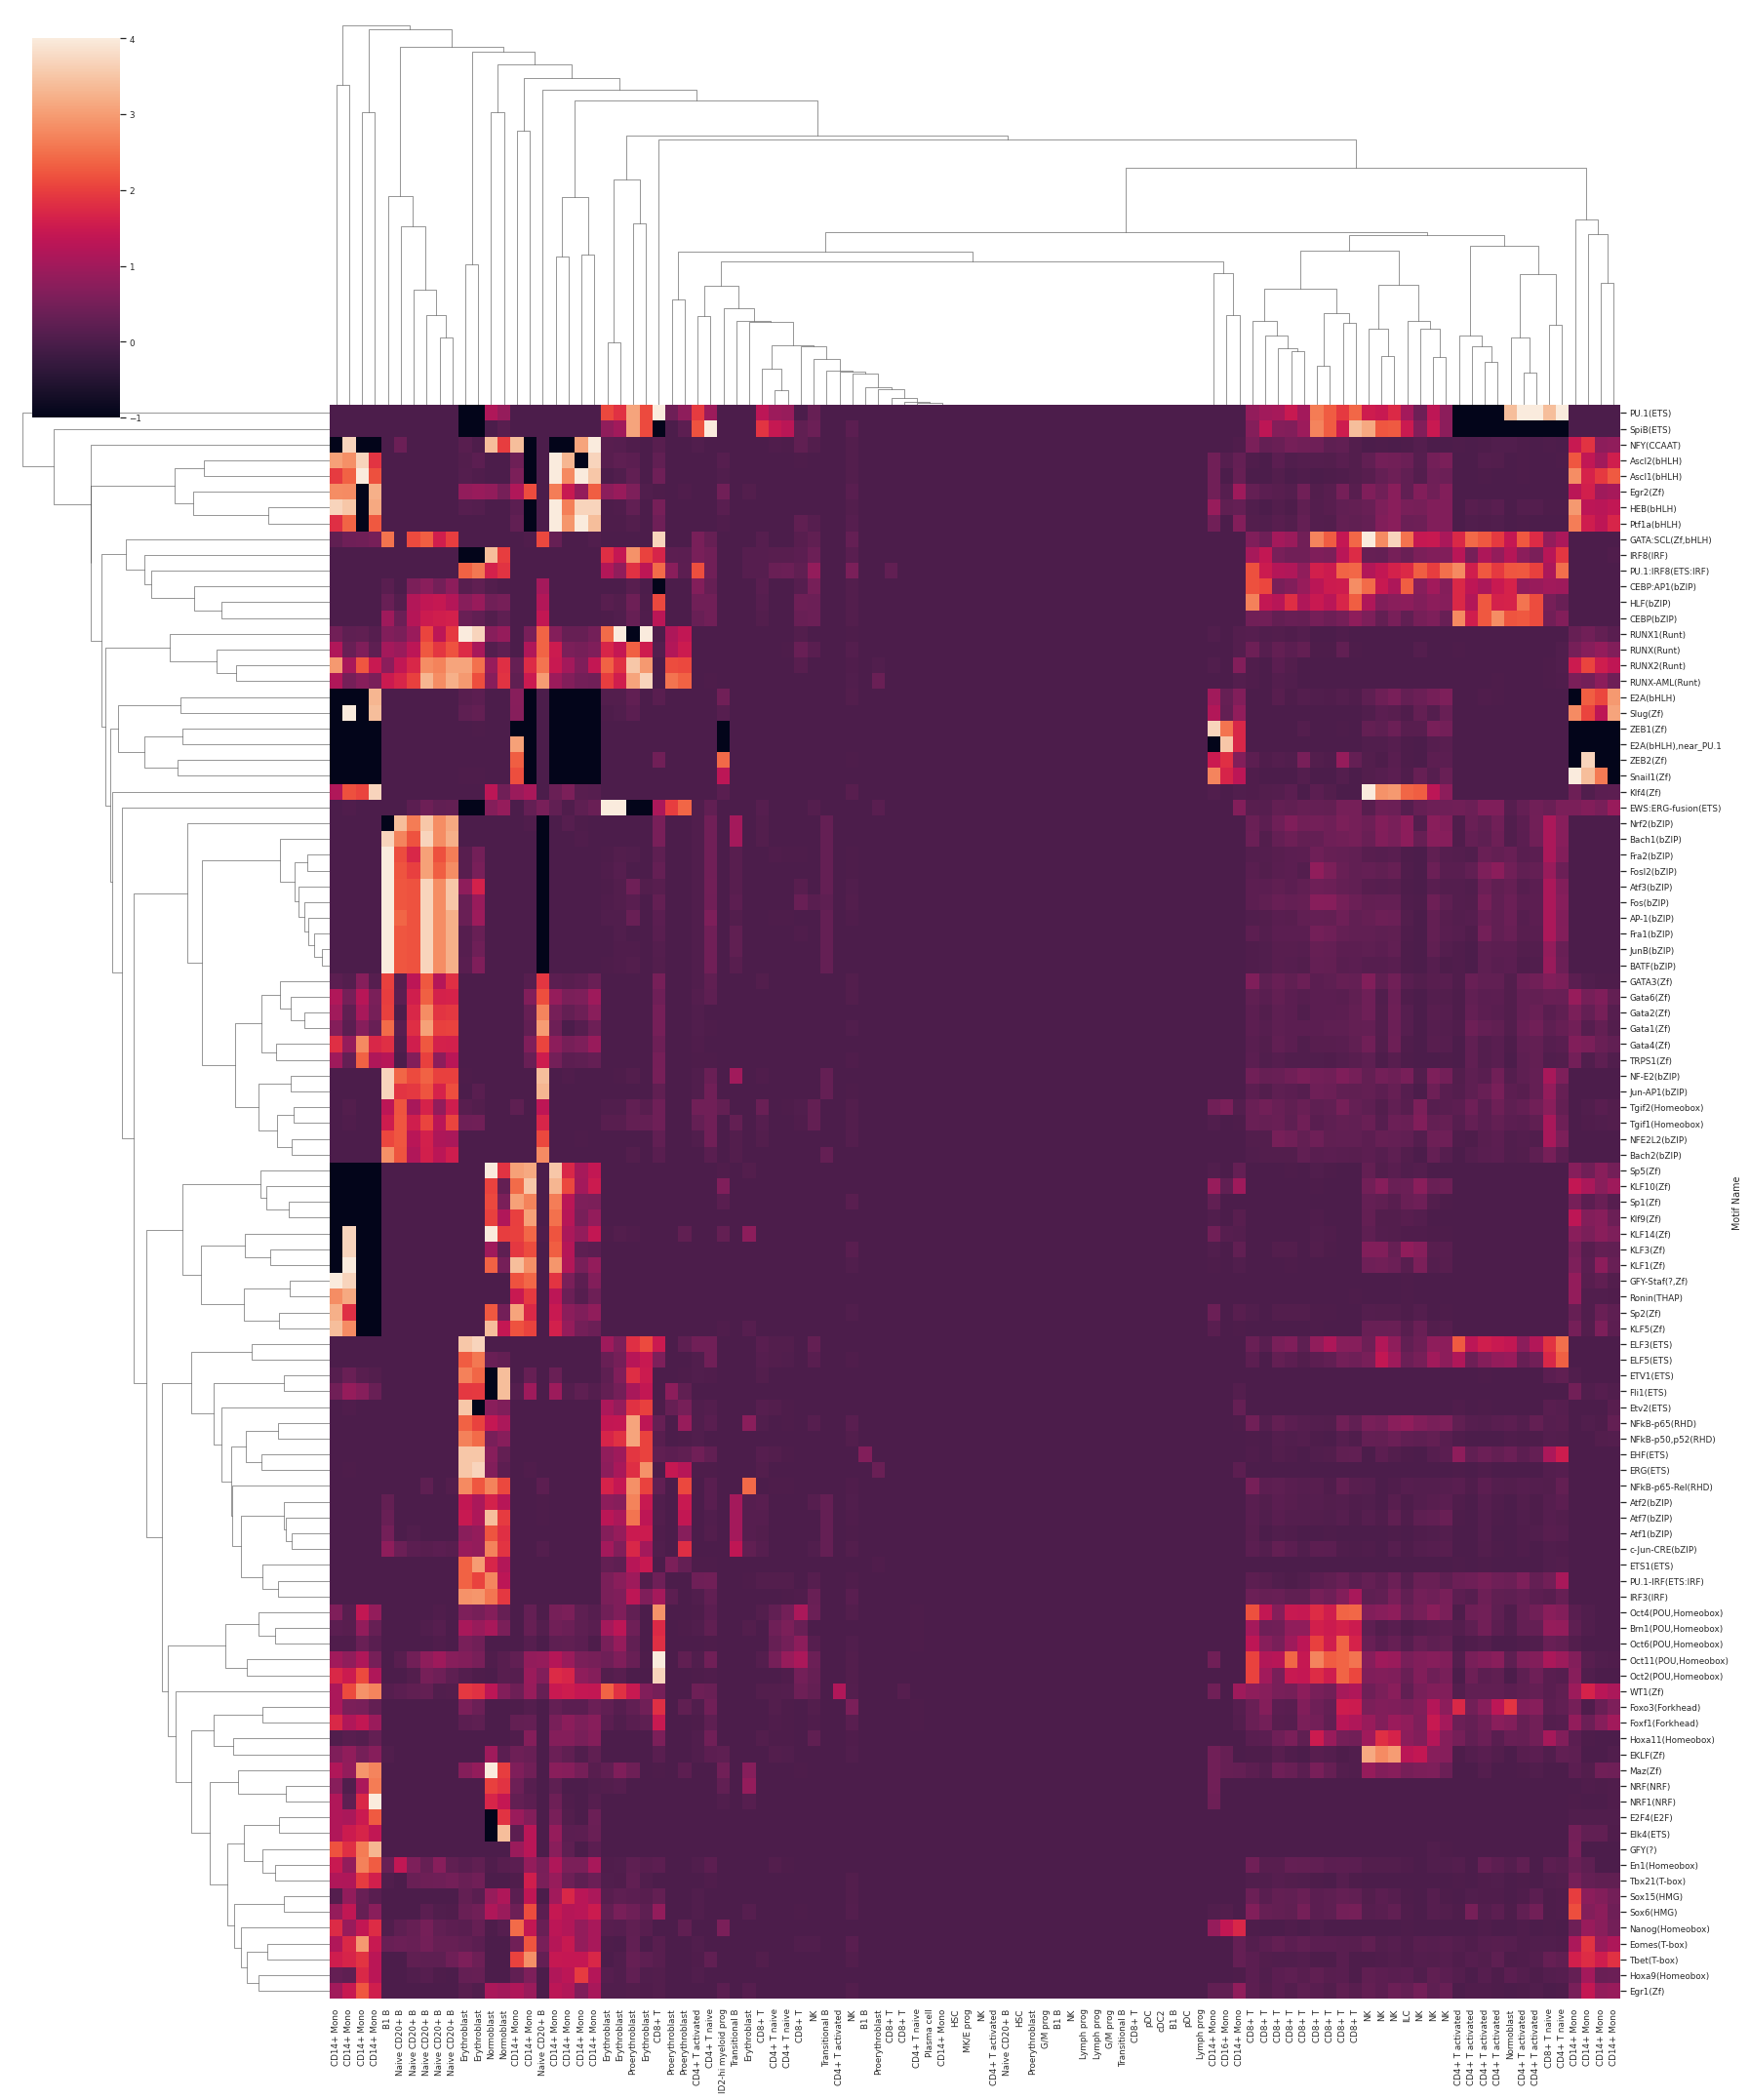

In [10]:
# enrichment results of selectively inaccessible promoters
sum_motif_inacc = sum_p_motif(acc='inacc', type='prom')
# each motif must be significantly enriched in at least 3 reference cells
sum_motif_inacc = sum_motif_inacc.loc[np.sum(sum_motif_inacc>-np.log10(0.05),axis=1)>2,:]
sns.set(font_scale=0.8)
g=sns.clustermap(sum_motif_inacc, figsize=(25,30))

/home/hliou/miniconda3/envs/mtproject/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/home/hliou/miniconda3/envs/mtproject/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


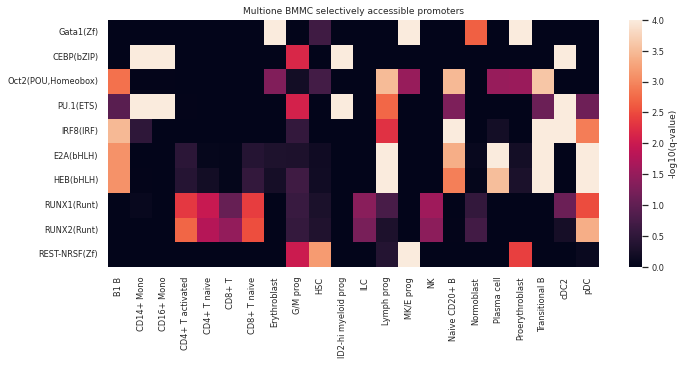

In [17]:
# make a heatmap with selected binding motifs
# selectively accessible promoters
df_acc = sum_p_motif(acc='acc', type='prom')
pplot_df = df_acc.reset_index()
m_l = ['Gata1(Zf)','CEBP(bZIP)','Oct2(POU,Homeobox)','PU.1(ETS)','IRF8(IRF)','E2A(bHLH)','HEB(bHLH)','RUNX1(Runt)','RUNX2(Runt)','REST-NRSF(Zf)']
data = []
for motif in m_l:
    row=pplot_df.loc[pplot_df['Motif Name']==motif,:].drop(['Motif Name'],axis=1)
    pval_df = pd.DataFrame({'cell_type':row.columns, motif:row.transpose().iloc[:,0]})
    df = pd.DataFrame({motif:pval_df.groupby(['cell_type'])[motif].mean()})
    data.append(df)
hm_df = pd.concat(data, axis=1)
fig, ax = plt.subplots(figsize=(hm_df.shape[0]/2,hm_df.shape[1]/2.2))
sns.heatmap(hm_df.transpose(), ax=ax, cbar_kws={'label': '-log10(q-value)'})
ax.set_xlabel('')
ax.set_title('Multione BMMC selectively accessible promoters')
plt.show()

/home/hliou/miniconda3/envs/mtproject/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/home/hliou/miniconda3/envs/mtproject/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


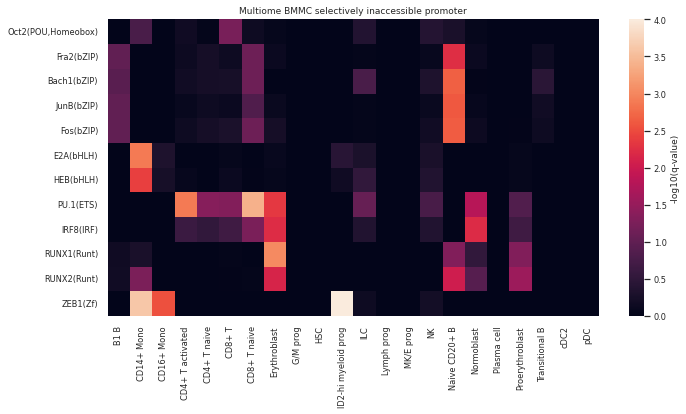

In [18]:
# selectively accessible promoters
df_inacc = sum_p_motif(acc='inacc', type='prom')
pplot_df = df_inacc.reset_index()
m_l = ['Oct2(POU,Homeobox)','Fra2(bZIP)','Bach1(bZIP)','JunB(bZIP)','Fos(bZIP)','E2A(bHLH)','HEB(bHLH)','PU.1(ETS)','IRF8(IRF)','RUNX1(Runt)','RUNX2(Runt)','ZEB1(Zf)']
data = []
for motif in m_l:
    row=pplot_df.loc[pplot_df['Motif Name']==motif,:].drop(['Motif Name'],axis=1)
    pval_df = pd.DataFrame({'cell_type':row.columns, motif:row.transpose().iloc[:,0]})
    df = pd.DataFrame({motif:pval_df.groupby('cell_type')[motif].mean()})
    data.append(df)
hm_df = pd.concat(data, axis=1)
fig, ax = plt.subplots(figsize=(hm_df.shape[0]/2,hm_df.shape[1]/2.2))
sns.heatmap(hm_df.transpose(), ax=ax, cbar_kws={'label': '-log10(q-value)'})
ax.set_xlabel('')
ax.set_title('Multiome BMMC selectively inaccessible promoter')
plt.show()

In [22]:
sns.reset_orig()

In [20]:
def ax_gene_expr(ax, gene, t=None):
    if t==None:
        t=gene

    gl = adata.var.loc[adata.var['feature_types']=='GEX'].index.to_list()
    icol = gl.index(gene)

    colors = np.array(adata.obsm['GEX_lognorm'][:,icol].todense())
    colors = [x[0] for x in colors]
    r=max(colors)-min(colors)
    colors = [x/r for x in colors]
    z = [x==0 for x in colors]
    nz = [x!=0 for x in colors]

    ax.scatter(wnn_umap2[z,0],wnn_umap2[z,1],c='whitesmoke',s=0.1,alpha=1)
    ax.scatter(wnn_umap2[nz,0],wnn_umap2[nz,1],c=list(compress(colors,nz)),cmap='Reds',s=0.1,alpha=1)
    ax.set_title(t, fontsize=20)
    ax.set_xticks([])
    ax.set_yticks([])
    

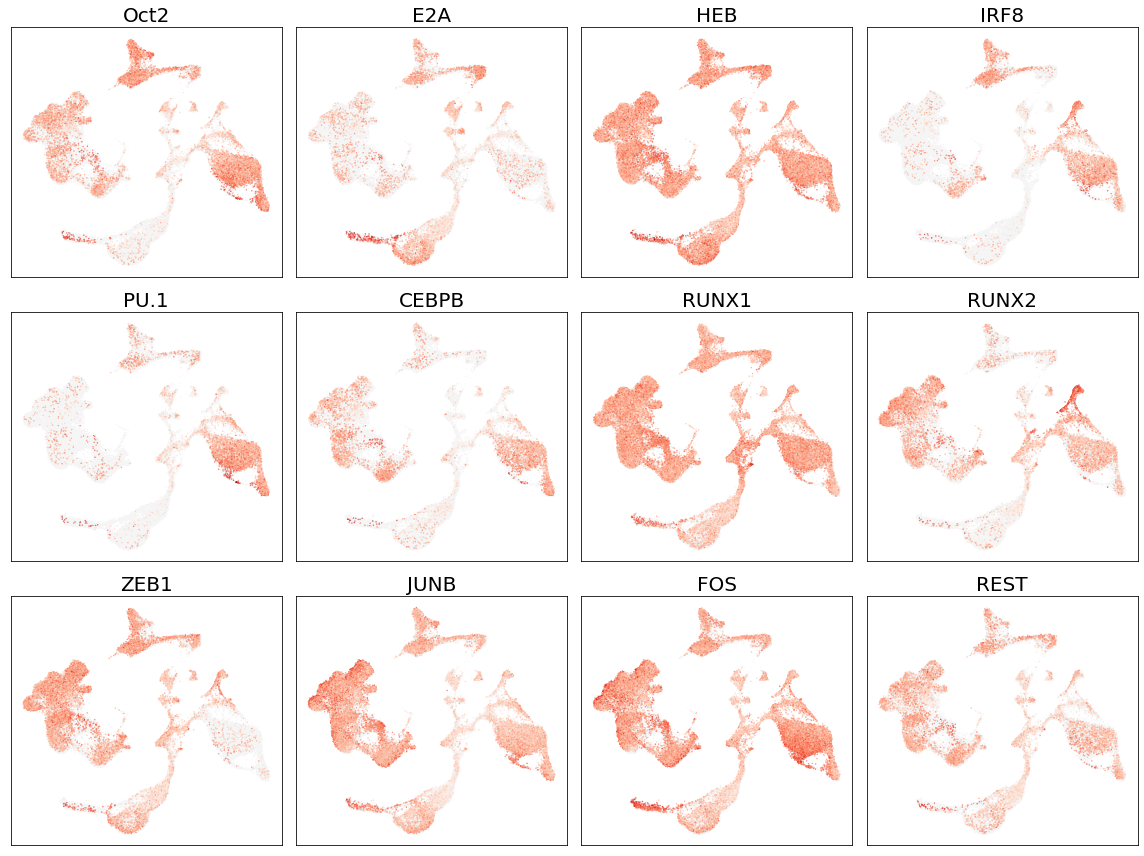

In [24]:
fig, axs = plt.subplots(3,4,figsize=(16,12))

ax_gene_expr(axs[0,0],'POU2F2',t='Oct2')
ax_gene_expr(axs[0,1],'TCF3', t='E2A')
ax_gene_expr(axs[0,2] ,'TCF12',t='HEB')
ax_gene_expr(axs[0,3],'IRF8')
ax_gene_expr(axs[1,0],'SPI1',t='PU.1')
ax_gene_expr(axs[1,1],'CEBPB')
ax_gene_expr(axs[1,2],'RUNX1')
ax_gene_expr(axs[1,3],'RUNX2')
ax_gene_expr(axs[2,0],'ZEB1')
ax_gene_expr(axs[2,1],'JUNB')
ax_gene_expr(axs[2,2],'FOS')
ax_gene_expr(axs[2,3],'REST')
fig.tight_layout()
plt.show()

In [17]:
# show cell types on the WNN UMAP embedding
def set_axis(ax):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
def myumap2_plot(umap, group_series, annotate=False, size=0.5):
    ## group:color dict
    group = group_series.unique()
    color = sns.color_palette('hsv',n_colors=len(group))
    #shuffle(color)
    color_dict = {group[x]:color[x] for x in range(len(group))}
    c=[color_dict[x] for x in group_series]
    ## Artist of the figure legend
    elements = [Line2D([0], [0], marker='o', color='w',
                        markerfacecolor=x, markersize=15) for x in color_dict.values()]

    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(umap[:,0],umap[:,1],c=c,s=size)
    ax.set_title('Multiome BMMC WNN')
    set_axis(ax)
    
    ignore_list = []
    if annotate:
        ## find the position of the first matched cell type
        for cell in group:
            if (group_series.value_counts()[cell] > 100) and (cell not in ignore_list):
                ct_id = np.where(group_series == cell)[0]
                ax.annotate(cell, (np.mean(umap[ct_id,0]), np.mean(umap[ct_id,1])),
                           bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'),
                           fontsize=8)
                  
    fig.legend(elements, color_dict.keys(), loc='upper center', bbox_to_anchor=(0.5, 0.1), ncol=4)
    plt.show()

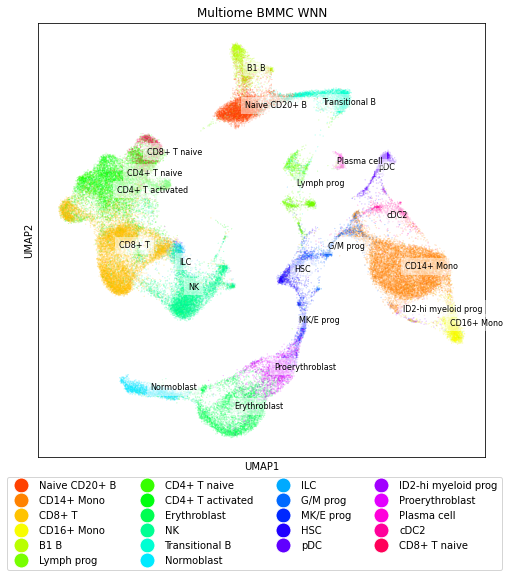

In [18]:
myumap2_plot(wnn_umap2, adata.obs['cell_type'], annotate=True, size=0.01)